# Experiment Design Lecture 3: Monte Carlo for Experimental Design

In this notebook, we'll cover some notes on the use of Monte Carlo sampling in experimental design, both in the construction and the use of response surfaces.

We won't cover the use of Monte Carlo for constructing response surfaces just yet (we need to cover response surfaces first). But we will cover how to implement Monte Carlo sampling, and how to visualize the resulting system responses.

## Overview

Monte Carlo sampling is essentially a brute-force technique in which random samples are taken until confidence that the entire space has been sampled is satisfactory.

Random numbers are used to create sampling points in each direction.

Think of Monte Carlo ray-tracing: you send out a whole bunch of rays, each in random directions, and from the result you determine the radiative flux. Mathematically, you're performing an integration by randomly sampling the function you want to integrate, then adding up all of the random samples: 

$$
\int f(x) dx \approx \frac{1}{N} \sum_{i} f( x_i ) 
$$

## Why Monte Carlo

So far we've been talking about expensive computer simulations and experimental systems, and trying to construct response surfaces to save us the time evaluating those functions. In this sense, Monte Carlo seems a bit out of place.

However, Monte Carlo has several uses in the context of experimental design. It is useful for systems with certain kinds of data, for which it can help construct response surfaces, and an important tool in using the constructed response surface.

### Monte Carlo for Response Surface Construction

So far we have talked about expensive experiments or simulations. When we say expensive, we've been implying they are expensive in resources - money, computational power, CPU cycles. 

But we can also do things that are computationally very simple, but that cost us time. For exmaple, consider an industrial plant with a central control system and a large number of sensors. We don't want the central control system to put everybody's instructions on hold because it hasn't gotten every temperature from every sensor. to break dependence on lag time, we might construct a response surface model for the sensor's value, which can be verified/updated using data as it is available.

Often these types of systems will also have a plethora of data available in data warehouses, which can also be utilized as Monte Carlo data (with care).

### Monte Carlo for Response Surface Evaluation

Once we have constructed the response surface to represent our expensive system, we may need to perform an analysis that involves integration of the response surface (for example, to estimate the mean response over a range of input variable values).

# Normalizing Variables for Monte Carlo

Before we go through an example of Monte Carlo sampling, we'll talk about how to normalize the parameter space of the models to make regression easier.

## Transforming Variables

For a distribution that is a function of $m$ variables $x_1, \dots, x_m$:

Each variable has its own range, $\alpha_i \leq x_i \leq \beta_i$

This range must be converted to $[0,1]$ by normalizing $x_i$:

$$
\hat{x}_i = \frac{ x_i - \alpha_i }{ \beta_i - \alpha_i }
$$

so that

$$
x_i \in \left[ 0, 1 \right] \forall i = 1 \dots m
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [2]:
def get_hat(x, log=False):
    """Given a non-normalized vector x
    with N elements between a and b,
    return a normalized vector xhat
    with N elements between 0 and 1.
    """
    a = x[0]
    b = x[-1]
    
    if(log):
        a = np.log10(a)
        b = np.log10(b)
        x = np.log10(x)
    
    xhat = (x-a)/(b-a)
    return xhat

def get_nohat(xhat, a, b):
    """Given a normalized vector xhat
    with N elements between 0 and 1,
    return a non-normalized vector x
    with N elements between a and b.
    """
    x = (b-a)*xhat + a
    return x

In [3]:
def func1():
    a = -150
    b = 750
    N = 15
    x = np.linspace(a,b,N)
    
    #xhat = (x - a)/(b - a)
    xhat = get_hat(x)
    
    print("x:")
    print(x)
    print("-"*20)
    print("xhat:")
    print(xhat)

In [4]:
func1()

x:
[-150.          -85.71428571  -21.42857143   42.85714286  107.14285714
  171.42857143  235.71428571  300.          364.28571429  428.57142857
  492.85714286  557.14285714  621.42857143  685.71428571  750.        ]
--------------------
xhat:
[ 0.          0.07142857  0.14285714  0.21428571  0.28571429  0.35714286
  0.42857143  0.5         0.57142857  0.64285714  0.71428571  0.78571429
  0.85714286  0.92857143  1.        ]


### Log Scale

If you're using a log scale, i.e. sampling logarithmically more at $\alpha$ than $\beta$:

$$
\hat{x}_i = \frac{ \log{(x_i)} - \log{(\alpha_i)} }{ \log{(\beta_i)} - \log{(\alpha_i)} } 
$$

In [5]:
def func2():
    a = 10
    b = 1000
    N = 15
    x = np.logspace(np.log10(a), np.log10(b), N)
    
    #xhat = (np.log10(x) - np.log10(a))/(np.log10(b) - np.log10(a))
    xhat = get_hat(x, log=True)
    
    print("x (logarithmic):")
    pprint(x)
    print("-"*20)
    print("xhat (linear):")
    pprint(xhat)

In [6]:
func2()

x (logarithmic):
array([   10.        ,    13.89495494,    19.30697729,    26.82695795,
          37.2759372 ,    51.79474679,    71.9685673 ,   100.        ,
         138.94954944,   193.06977289,   268.26957953,   372.75937203,
         517.94746792,   719.685673  ,  1000.        ])
--------------------
xhat (linear):
array([ 0.        ,  0.07142857,  0.14285714,  0.21428571,  0.28571429,
        0.35714286,  0.42857143,  0.5       ,  0.57142857,  0.64285714,
        0.71428571,  0.78571429,  0.85714286,  0.92857143,  1.        ])


## Selecting Samples

In general a sample of uniform random numbers of dimensionality $d \times n$, where $d$ is the input vector dimensionality and $n$ is the number of random Monte Carlo samples, is created between a lower and upper bound. (Note that depending on how we define parameter uncertainty we may want these to be normally distributed variables.)

The system response function $f(x_i)$ is evaluated to obtain the system response quantity $y$.

The random input vector and its corresponding output vector are saved.

# Examples

We'll look at a few examples implementing MC (though we won't yet cover response surface applications). Two examples:
* Utilizing MC to visualize a simple function response
* Utilizing MC to visualize an expensive function response

## Simple Function Response

We will consider a two dimensional black box function and how we can utilize Monte Carlo to answer some of the following questions:

* What does the "true" system response function $f(x_i)$ look like?
* Is the response smooth enough to model with a polynomial?
* What degree of polynomial would be appropriate for a response surface model?

The black box system response function we'll consider is a function of two input variables:

$$
y = f(x_1,x_2) = \cos \left( \sqrt{x_1}\sqrt{x_2} \right)
$$

over the domain $x_1 \in [0,1], x_2 \in [0,1]$.

### Visualizing Analytical Response

In [7]:
def f(x1, x2):
    return np.cos(np.sqrt(x1)*np.sqrt(x2))

In [40]:
def plot_response_contourf():
    
    N = 20
    x1 = np.linspace(0,1,N)
    x2 = np.linspace(0,1,N)
    
    # For labeling/evaluating function
    X1,X2 = np.meshgrid(x1,x2)
    
    # Contour plot of f(x,y)
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1,1,1)
    c = ax.contourf(X1, X2, f(X1,X2), cmap='binary')
    
    ax.set_title('Analytical System Response Function')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_aspect('equal')
    plt.colorbar(c)
    plt.show()

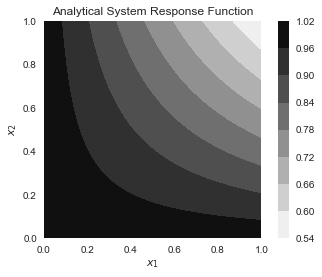

In [41]:
plot_response_contourf()

### Visualizing Monte Carlo Results

Next we'll make a 3D scatterplot of 10,000 random Monte Carlo samples of $f(x_1, x_2)$, to illustrate how to get a sense of the sense of the response surface shape without an analytical expression.

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [43]:
def sample_response(N = 10):
    """Generate N random MC samples of (x,y) space"""
    # Sample space: x1 in [0,1], x2 in [0,1]
    # (Otherwise, would need to do re-scaling before return)
    # Generate N random (x,y) values between 0 and 1
    return np.random.uniform(0, 1, size=(2,N))

In [44]:
def plot_response_MCscatter():

    # ----------------------
    # Generate MC samples for scatter points
    N = 10000
    rv = sample_response(N)
    xx1 = rv[0,:]
    xx2 = rv[1,:]
    yy = f(xx1,xx2)
    
    # ----------------------
    # Generate analytical function for wireframe plot
    N = 20
    x1 = np.linspace(0,1,N)
    x2 = np.linspace(0,1,N)
    X1,X2 = np.meshgrid(x1,x2)

    # ----------------------
    # Plot the analytical and Monte Carlo results
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Purple wireframe = analytical response surface
    ax.plot_wireframe(X1, X2, f(X1, X2),
                  alpha=0.3, 
                  color='purple',
                  label="Analytical")

    # Blue scatterplot = MC samples
    ax.scatter(xx1, xx2, yy, s=0.3,
               label="MC", linewidths=1)

    ax.view_init(elev=50., azim=200)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_zlabel(r'$y$')
    ax.legend()
    ax.set_title("Monte Carlo Samples \nPlus Analytical System Response")

    plt.show()

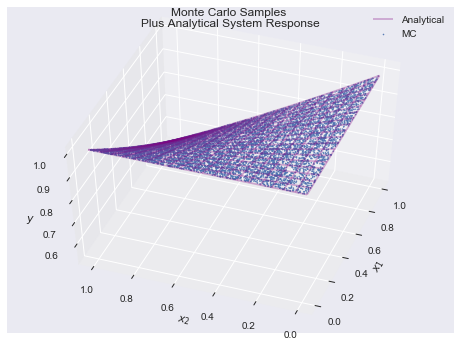

In [45]:
plot_response_MCscatter()

## A More Complicated Function: Heat Transfer

Now let's look at a more complicated function from a heat transfer application. As a reminder, $x$ and $y$ are parameters for the system response $f(x_1,x_2)$, and the function is being sampled with Monte Carlo. Here we will look at a system response $f(x_1, x_2)$ that is an integrated quantity (that is, evaluating $f(x_1, x_2)$ involves integrating a differential equation).

### System Governing Equation

(heat = energy transfer)

Consider the energy balance over a system that has a single uniform temperature $T$ and is characterized by some time scale $t_0$. 

Now introduce normalized system temperature $\theta = \dfrac{T - T_0}{T_1 - T_0}$ and normalized time $\tau = \dfrac{t}{t_0}$. 

From an energy balance (via the First Law of Thermodynamics), we know:

$$
dE = dQ + dE \\
\dfrac{dE}{dt} = \dot{Q} + \dot{W}
$$

That is, the system temperature changes due to heat and work being added or removed from the system. If we consider a perfectly insulated container at a uniform initial temperature, there is no heat exchanged with the surroundings and the system does no work so the temperature stays constant.

(Note: the system is closed with respect to mass flow, so use closed version of First Law.)

Now suppose a heat exchanger is suddenly introduced at time $t = 0$. This heat exchanger allows the system to exchange energy with its surroundings (imagine a container of hot gas, with a thick insulated covering over a glass window. If the cover is suddenly removed so that the inside of the container can be observed, the system suddenly begins to lose energy to its surroundings.)

Via Newton's Law of Cooling, the heat flux through the heat exchanger or glass window is given by:

$$
\dot{Q} = - h A ( T_{system} - T_{ambient})
$$

where a negative $\dot{Q}$ indicates heat leaves the system. (If the system temperature is higher than the ambient temperature, the system will lose heat and the system temperature will decrease.)

If we consider an insulated container at uniform temperature, we can think about a physical analgoy to a sudden temperature sink being introduced.

If we consider a vessel with a glass viewport, covered with a thick insulated flap, the vessel would normally be adiabatic and the viewport covered. However, if the flap suddenly opened to look into the viewport, a heat sink term that is modeled using the equation above (gradient-based transport) would apply to the non-insulated portions.

### Energy Equation

into which a heat source or sink is introduced, the differential equation describing the temperature change is:

$$
\dfrac{d \theta}{dt} = \beta \theta
$$

where $\beta$ is a heat transfer coefficient. For this simple differential equation we can still obtain an analytical solution for temperature after time $t$,

$$
\ln \left( \dfrac{ \theta(t) }{ \theta(0) } \right) = - \beta
$$

or,

$$
\theta(t) = \theta_0 \exp \left( - \beta t \right)
$$

where $\theta_0 = \theta(t=0)$. 

### Numerical Approximation of System Response

However, in general we are interested in evaluating functions too complex to integrate analytically, so we utilize an approximation technique that only involves evaluating the function numerically to integrate it:

$$
\dfrac{d \theta}{dt} \approx \dfrac{\Delta \theta}{\Delta t} = \dfrac{\theta_{i+1} - \theta_i}{\Delta t}
$$

Now if we set that equal to the right side of $\frac{d \theta}{d t} = \beta \theta$, and write it for every single time step, and sum them all up over the $N_t$ timesteps over the entire time period $t_0$ to $t_f$, we get an approximation of the exact integral of the RHS $\beta \theta$:

$$
\theta_f = \theta_0 + \sum_{j=1}^{N_t} \beta_j \theta_j \Delta t_j
$$

where $N_t = \dfrac{t}{\Delta t}$.

### Summary: Temperature Equations

To summarize: the analytical expression we use for the temperature as a function of time comes from the integrated form of the differential energy balance; the numerical approximation comes from applying a simple backward difference scheme to the time derivative in the original differential equation. The former is more accurate but not always available, so we're mainly interested in the latter for its robustness.

Analytical:

$$
\theta(t) = \theta_0 \exp \left( - \beta t \right)
$$

Numerical:

$$
\theta(t) \approx \theta_0 + \sum_{j=1}^{N_t} \beta_j \theta_j \Delta t_j
$$

### Heat Transfer Coefficient Parameters

We still need to relate the energy balance to the input parameters and the system response function $f(x_1, x_2)$.

The system response we are interested in is the integrated system temperature after some fixed time window (arbitrarily say, $t=2$):

$$
f(x_1, x_2) = \theta(t) = \theta_0 \exp \left( - \beta t \right)
$$

The two input parameters to the model:
* Initial temperature of the reactor $\theta(0)$
* Heat transfer coefficient $\beta$

The input parameter $x_1$ can be used as the value of $\theta(0)$:

$$
\theta_0 = x_1
$$

$x_1 = 0$ corresponds to an initial temperature of $T_0$, while $x_1 = 1$ corresponds to an initial temperature of $T_1$.

The input parameter $x_2$ can be used to control the heat transfer coefficient. Heat transfer coefficient correlations often take the form of rational functions, so we use the following rational function for $\beta(x_2)$:

$$
\beta = \dfrac{x_2^2}{1 + x_2^2}
$$

The final right-hand side for the analytical version is therefore:

$$
f(x_1, x_2) = \theta(t) = x_1 \exp \left( - \left( \dfrac{ x_2^2 }{1 + x_2^2} \right) t \right)
$$

The right-hand side for the numerical version is:



$$
f(x_1, x_2) = \theta(t) = \theta_0 + \int_{0}^{t} \beta t' dt' 
$$

Approximated via:

$$
f(x_1, x_2) \approx x_1 + \left( \dfrac{ x_2^2 }{1 + x_2^2} \right) \Delta t \sum_{j=1}^{N_t} \theta_j
$$

or, replacing the numerical integral approximation with a call to the `odeint` function from scipy, this becomes:

$$
f(x_1, x_2) \approx x_1 + \mbox{odeint}\left( \mbox{RHS}, \theta_0, t, \dots \right)
$$


In [95]:
from scipy.integrate import odeint

In [137]:
def beta(x):
    return (x**2)/(1+x**2)

def rhs(theta, t, x1, x2):
    """Computes the RHS of derivative of theta at t"""
    return -beta(x2)*theta

def solve_ht_rhs(x1,x2):
    y0 = x1
    b = beta(x2)
    tf = 2
    Nt = 1000
    t = np.linspace(0, tf, Nt)
    soln = odeint(rhs, y0, t, args=(x1,x2))
    return t, soln

def eval_ht_rhs(x1,x2):
    tf = 2
    Nt = 1000
    t = np.linspace(0, tf, Nt)
    return t, x1*np.exp(-beta(x2)*t)

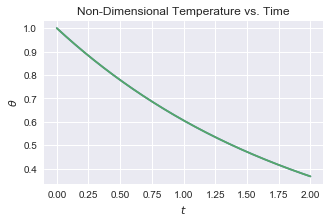

In [150]:
t, theta = solve_ht_rhs(1,1)
t, theta_e = eval_ht_rhs(1,1)

fig, ax = plt.subplots(1,1,figsize=(5,3))

ax.plot(t, theta, '-')
ax.plot(t, theta_e, '-')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\theta$')
ax.set_title("Non-Dimensional Temperature vs. Time")
plt.show()

The numerical and analytical outcomes of the integrated time-temperature profile overlap nearly exactly. 

*However*, it is important to note that this is still not quite to the $f(x_1, x_2)$ function we really want. That function $f$ should not return the entire time-temperature history of the system, but rather should only return the final time-temperature state of the reactor.

In [206]:
def beta(x):
    return (x**2)/(1+x**2)

def rhs(theta, t, x1, x2):
    """Computes the RHS of derivative of theta at t"""
    return -beta(x2)*theta

def f_ht_solve(x1, x2):
    """System response function for 
    single pair of input values.
    
    Returns integrated non-dim temperature (theta) 
    after 2 time units.
    
    Called by f_ht_solve_grid().
    """
    tf = 2
    Nt = 1000
    t = np.linspace(0, tf, Nt)
    
    y0 = x1
    b = beta(x2)
            
    solution = odeint(rhs, y0, t, args=(x1, x2))
    solution = np.squeeze(solution)[-1]             
    return solution
    
def f_ht_solve_grid(x1s,x2s):
    """System response function for 
    input vectors x1, x2 coming in from
    a meshgrid function call.
    
    Returns values of f(x1,x2) on the 
    same meshgrid.
    """
    # Create container for solutions,
    # same size as inputl
    solutions = np.zeros(np.shape(x1s))
    for i in range(np.shape(x1s)[0]):
        for j in range(np.shape(x1s)[1]):
            
            x1 = x1s[i][j]
            x2 = x2s[i][j]
            
            solutions[i][j] = f_ht_solve(x1,x2)
    
    return solutions

def f_ht_eval(x1,x2):
    """Returns analytical system response function
    for heat transfer system (non-dimensionalized
    temperature theta after t = 2 time units).
    """
    tf = 2
    Nt = 1000
    t = np.linspace(0, tf, Nt)
    y = x1*np.exp(-beta(x2)*t)
    return y[-1]

Now that we have defined the right hand side $f(x_1, x_2)$, we can test out how it is supposed to work. We should be able to pass input parameters $x_1, x_2$ in, and get a single value out - the integrated, non-dimensional temperature $\theta(t)$ after $t = 2$ time units.

In [207]:
print("These should both be ~0.35 (see graph above)")
print("and should be approximately equal:")
print(f_ht_solve(1,1))
print(f_ht_eval(1,1))

These should both be ~0.35 (see graph above)
and should be approximately equal:
0.367879445848
0.367879441171


## Computing Response Surface

### A Note on Visualization

### A Note on Coefficient and Variable Order

### Polynomial Powers Matrix

### Quadratic Surface, 6 Dimensions

### Quadratic Surface, 2 Dimensions

### Cubic Surface, 6 Dimensions

### Quartic Response Surface

# References